In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV

In [2]:
## Lets load the data

full_df_NO2 = pd.read_pickle("../NO/full_df_2021_NOX.pkl")
pd.set_option('display.max_columns', None)

## This the data cleaning. Keeping only the relevant features and removing the less than equal to zero target values

cols=[i for i in range(1,28)]
df1= full_df_NO2.drop(full_df_NO2.columns[cols], axis=1)
df2 = df1.drop(df1.columns[[2,3,4,5,6,9]], axis=1) 
j=[]
for i in range(4,72):
    j.append(i)
df3 = df2.drop(df2.columns[j], axis=1) 
df4 = df3.drop(df3.columns[[11,12,13,14,15,16,17,18]], axis=1) 
df4 = df4.drop(df4.columns[6], axis=1) 

df4.rename(columns={'pda': 'Average Pupil Diameter (mm)', 'pup_dis': 'Pupil Distance (mm)','pd_diff': 'Difference in Pupil Diameter (mm)', 'ECG.': 'ECG (V)','Resp.': 'Respiration Rate (brpm)','Temp.': 'Skin Temperature ($\mathrm{^o C})$','HR': 'Heart Rate (bpm)','NO2':'$\mathrm{NO_2}$ (ppb)','SpO2':'$\mathrm{SpO_2}$ (%)','GSR':'GSR ($\mathrm{\mu S}$)'}, inplace=True)
df_final = df4[df4['$\mathrm{NO_2}$ (ppb)'] >=0]

pd.options.mode.chained_assignment = None ## apparently this needs to be added to overcome an error i dont understand  

df_final['$\mathrm{SpO_2}$ (%)']=df_final['$\mathrm{SpO_2}$ (%)']*1000000 ## change the SpO2 to percentage
df_final['GSR ($\mathrm{\mu S}$)']=df_final['GSR ($\mathrm{\mu S}$)']*1000 ## convert kiloohms to ohms
df_final['GSR ($\mathrm{\mu S}$)']=1/df_final['GSR ($\mathrm{\mu S}$)']  ## convert ohms to siemans by taking the reciprocal
df_final['GSR ($\mathrm{\mu S}$)']=df_final['GSR ($\mathrm{\mu S}$)']*1000000 ## convert siemens to microsiemens

j=[]
for i in range(10,330):
    j.append(i)
df_final = df_final.drop(df_final.columns[j], axis=1) 
df_final

,$\mathrm{NO_2}$ (ppb),Average Pupil Diameter (mm),Pupil Distance (mm),Difference in Pupil Diameter (mm),ECG (V),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$
dateTime,,,,,,,,,,
2021-05-26 11:45:59.927799,12.4,4.155,65.24,-0.09,-0.000408,46.216525,100.0,84.0,0.080112,30.1875
2021-05-26 11:46:04.932462,12.6,3.525,65.22,0.11,-0.000526,44.886883,99.0,87.0,0.079841,30.1875
2021-05-26 11:46:09.932680,12.9,3.550,65.06,0.08,-0.000304,45.207832,98.0,88.0,0.079572,30.0625
2021-05-26 11:46:14.919361,13.1,3.395,65.17,0.11,-0.000389,44.520084,98.0,85.0,0.079706,30.0625
2021-05-26 11:46:19.922578,13.4,3.835,65.03,0.29,-0.000389,44.336684,99.0,82.0,0.079706,30.0625
...,...,...,...,...,...,...,...,...,...,...
2021-06-10 11:26:26.068698,16.4,2.750,65.90,0.02,-0.001450,28.931178,97.0,120.0,0.091122,29.3750
2021-06-10 11:26:31.056772,16.9,2.595,65.29,0.11,-0.001048,29.297976,96.0,120.0,0.091181,29.3750
2021-06-10 11:26:41.060407,14.9,2.615,66.04,0.05,-0.001223,27.463986,96.0,122.0,0.091682,29.4375


In [3]:
## lets load the old PSD dataframe

old_psd=pd.read_pickle('../WM_PSD/Entire_PSD_WM.pkl')
old_psd

,Fp1-delta_WM,Fp1-theta_WM,Fp1-alpha_WM,Fp1-beta_WM,Fp1-gamma_WM,Fp2-delta_WM,Fp2-theta_WM,Fp2-alpha_WM,Fp2-beta_WM,Fp2-gamma_WM,F3-delta_WM,F3-theta_WM,F3-alpha_WM,F3-beta_WM,F3-gamma_WM,F4-delta_WM,F4-theta_WM,F4-alpha_WM,F4-beta_WM,F4-gamma_WM,C3-delta_WM,C3-theta_WM,C3-alpha_WM,C3-beta_WM,C3-gamma_WM,C4-delta_WM,C4-theta_WM,C4-alpha_WM,C4-beta_WM,C4-gamma_WM,P3-delta_WM,P3-theta_WM,P3-alpha_WM,P3-beta_WM,P3-gamma_WM,P4-delta_WM,P4-theta_WM,P4-alpha_WM,P4-beta_WM,P4-gamma_WM,O1-delta_WM,O1-theta_WM,O1-alpha_WM,O1-beta_WM,O1-gamma_WM,O2-delta_WM,O2-theta_WM,O2-alpha_WM,O2-beta_WM,O2-gamma_WM,F7-delta_WM,F7-theta_WM,F7-alpha_WM,F7-beta_WM,F7-gamma_WM,F8-delta_WM,F8-theta_WM,F8-alpha_WM,F8-beta_WM,F8-gamma_WM,T7-delta_WM,T7-theta_WM,T7-alpha_WM,T7-beta_WM,T7-gamma_WM,T8-delta_WM,T8-theta_WM,T8-alpha_WM,T8-beta_WM,T8-gamma_WM,P7-delta_WM,P7-theta_WM,P7-alpha_WM,P7-beta_WM,P7-gamma_WM,P8-delta_WM,P8-theta_WM,P8-alpha_WM,P8-beta_WM,P8-gamma_WM,Fz-delta_WM,Fz-theta_WM,Fz-alpha_WM,Fz-beta_WM,Fz-gamma_WM,Cz-delta_WM,Cz-theta_WM,Cz-alpha_WM,Cz-beta_WM,Cz-gamma_WM,Pz-delta_WM,Pz-theta_WM,Pz-alpha_WM,Pz-beta_WM,Pz-gamma_WM,Oz-delta_WM,Oz-theta_WM,Oz-alpha_WM,Oz-beta_WM,Oz-gamma_WM,FC1-delta_WM,FC1-theta_WM,FC1-alpha_WM,FC1-beta_WM,FC1-gamma_WM,FC2-delta_WM,FC2-theta_WM,FC2-alpha_WM,FC2-beta_WM,FC2-gamma_WM,CP1-delta_WM,CP1-theta_WM,CP1-alpha_WM,CP1-beta_WM,CP1-gamma_WM,CP2-delta_WM,CP2-theta_WM,CP2-alpha_WM,CP2-beta_WM,CP2-gamma_WM,FC5-delta_WM,FC5-theta_WM,FC5-alpha_WM,FC5-beta_WM,FC5-gamma_WM,FC6-delta_WM,FC6-theta_WM,FC6-alpha_WM,FC6-beta_WM,FC6-gamma_WM,CP5-delta_WM,CP5-theta_WM,CP5-alpha_WM,CP5-beta_WM,CP5-gamma_WM,CP6-delta_WM,CP6-theta_WM,CP6-alpha_WM,CP6-beta_WM,CP6-gamma_WM,FT9-delta_WM,FT9-theta_WM,FT9-alpha_WM,FT9-beta_WM,FT9-gamma_WM,FT10-delta_WM,FT10-theta_WM,FT10-alpha_WM,FT10-beta_WM,FT10-gamma_WM,FCz-delta_WM,FCz-theta_WM,FCz-alpha_WM,FCz-beta_WM,FCz-gamma_WM,AFz-delta_WM,AFz-theta_WM,AFz-alpha_WM,AFz-beta_WM,AFz-gamma_WM,F1-delta_WM,F1-theta_WM,F1-alpha_WM,F1-beta_WM,F1-gamma_WM,F2-delta_WM,F2-theta_WM,F2-alpha_WM,F2-beta_WM,F2-gamma_WM,C1-delta_WM,C1-theta_WM,C1-alpha_WM,C1-beta_WM,C1-gamma_WM,C2-delta_WM,C2-theta_WM,C2-alpha_WM,C2-beta_WM,C2-gamma_WM,P1-delta_WM,P1-theta_WM,P1-alpha_WM,P1-beta_WM,P1-gamma_WM,P2-delta_WM,P2-theta_WM,P2-alpha_WM,P2-beta_WM,P2-gamma_WM,AF3-delta_WM,AF3-theta_WM,AF3-alpha_WM,AF3-beta_WM,AF3-gamma_WM,AF4-delta_WM,AF4-theta_WM,AF4-alpha_WM,AF4-beta_WM,AF4-gamma_WM,FC3-delta_WM,FC3-theta_WM,FC3-alpha_WM,FC3-beta_WM,FC3-gamma_WM,FC4-delta_WM,FC4-theta_WM,FC4-alpha_WM,FC4-beta_WM,FC4-gamma_WM,CP3-delta_WM,CP3-theta_WM,CP3-alpha_WM,CP3-beta_WM,CP3-gamma_WM,CP4-delta_WM,CP4-theta_WM,CP4-alpha_WM,CP4-beta_WM,CP4-gamma_WM,PO3-delta_WM,PO3-theta_WM,PO3-alpha_WM,PO3-beta_WM,PO3-gamma_WM,PO4-delta_WM,PO4-theta_WM,PO4-alpha_WM,PO4-beta_WM,PO4-gamma_WM,F5-delta_WM,F5-theta_WM,F5-alpha_WM,F5-beta_WM,F5-gamma_WM,F6-delta_WM,F6-theta_WM,F6-alpha_WM,F6-beta_WM,F6-gamma_WM,C5-delta_WM,C5-theta_WM,C5-alpha_WM,C5-beta_WM,C5-gamma_WM,C6-delta_WM,C6-theta_WM,C6-alpha_WM,C6-beta_WM,C6-gamma_WM,P5-delta_WM,P5-theta_WM,P5-alpha_WM,P5-beta_WM,P5-gamma_WM,P6-delta_WM,P6-theta_WM,P6-alpha_WM,P6-beta_WM,P6-gamma_WM,AF7-delta_WM,AF7-theta_WM,AF7-alpha_WM,AF7-beta_WM,AF7-gamma_WM,AF8-delta_WM,AF8-theta_WM,AF8-alpha_WM,AF8-beta_WM,AF8-gamma_WM,FT7-delta_WM,FT7-theta_WM,FT7-alpha_WM,FT7-beta_WM,FT7-gamma_WM,FT8-delta_WM,FT8-theta_WM,FT8-alpha_WM,FT8-beta_WM,FT8-gamma_WM,TP7-delta_WM,TP7-theta_WM,TP7-alpha_WM,TP7-beta_WM,TP7-gamma_WM,TP8-delta_WM,TP8-theta_WM,TP8-alpha_WM,TP8-beta_WM,TP8-gamma_WM,PO7-delta_WM,PO7-theta_WM,PO7-alpha_WM,PO7-beta_WM,PO7-gamma_WM,PO8-delta_WM,PO8-theta_WM,PO8-alpha_WM,PO8-beta_WM,PO8-gamma_WM,Fpz-delta_WM,Fpz-theta_WM,Fpz-alpha_WM,Fpz-beta_WM,Fpz-gamma_WM,CPz-delta_WM,CPz-theta_WM,CPz-alpha_WM,CPz-beta_WM,CPz-gamma_WM,POz-delta_WM,POz-theta_WM,POz-alpha_WM,POz-beta_WM,POz-gamma_WM,TP10-delta_WM,TP10-theta_WM,TP10-alpha_WM,TP10-beta_WM,TP10-gamma_WM
dateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [4]:
## lets merge it

tol_2 = pd.Timedelta('1s')
full_df = pd.merge_asof(left=df_final, right=old_psd, right_index=True, left_index=True, direction='nearest', tolerance=tol_2)
df_final=full_df
df_final

,$\mathrm{NO_2}$ (ppb),Average Pupil Diameter (mm),Pupil Distance (mm),Difference in Pupil Diameter (mm),ECG (V),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$,Fp1-delta_WM,Fp1-theta_WM,Fp1-alpha_WM,Fp1-beta_WM,Fp1-gamma_WM,Fp2-delta_WM,Fp2-theta_WM,Fp2-alpha_WM,Fp2-beta_WM,Fp2-gamma_WM,F3-delta_WM,F3-theta_WM,F3-alpha_WM,F3-beta_WM,F3-gamma_WM,F4-delta_WM,F4-theta_WM,F4-alpha_WM,F4-beta_WM,F4-gamma_WM,C3-delta_WM,C3-theta_WM,C3-alpha_WM,C3-beta_WM,C3-gamma_WM,C4-delta_WM,C4-theta_WM,C4-alpha_WM,C4-beta_WM,C4-gamma_WM,P3-delta_WM,P3-theta_WM,P3-alpha_WM,P3-beta_WM,P3-gamma_WM,P4-delta_WM,P4-theta_WM,P4-alpha_WM,P4-beta_WM,P4-gamma_WM,O1-delta_WM,O1-theta_WM,O1-alpha_WM,O1-beta_WM,O1-gamma_WM,O2-delta_WM,O2-theta_WM,O2-alpha_WM,O2-beta_WM,O2-gamma_WM,F7-delta_WM,F7-theta_WM,F7-alpha_WM,F7-beta_WM,F7-gamma_WM,F8-delta_WM,F8-theta_WM,F8-alpha_WM,F8-beta_WM,F8-gamma_WM,T7-delta_WM,T7-theta_WM,T7-alpha_WM,T7-beta_WM,T7-gamma_WM,T8-delta_WM,T8-theta_WM,T8-alpha_WM,T8-beta_WM,T8-gamma_WM,P7-delta_WM,P7-theta_WM,P7-alpha_WM,P7-beta_WM,P7-gamma_WM,P8-delta_WM,P8-theta_WM,P8-alpha_WM,P8-beta_WM,P8-gamma_WM,Fz-delta_WM,Fz-theta_WM,Fz-alpha_WM,Fz-beta_WM,Fz-gamma_WM,Cz-delta_WM,Cz-theta_WM,Cz-alpha_WM,Cz-beta_WM,Cz-gamma_WM,Pz-delta_WM,Pz-theta_WM,Pz-alpha_WM,Pz-beta_WM,Pz-gamma_WM,Oz-delta_WM,Oz-theta_WM,Oz-alpha_WM,Oz-beta_WM,Oz-gamma_WM,FC1-delta_WM,FC1-theta_WM,FC1-alpha_WM,FC1-beta_WM,FC1-gamma_WM,FC2-delta_WM,FC2-theta_WM,FC2-alpha_WM,FC2-beta_WM,FC2-gamma_WM,CP1-delta_WM,CP1-theta_WM,CP1-alpha_WM,CP1-beta_WM,CP1-gamma_WM,CP2-delta_WM,CP2-theta_WM,CP2-alpha_WM,CP2-beta_WM,CP2-gamma_WM,FC5-delta_WM,FC5-theta_WM,FC5-alpha_WM,FC5-beta_WM,FC5-gamma_WM,FC6-delta_WM,FC6-theta_WM,FC6-alpha_WM,FC6-beta_WM,FC6-gamma_WM,CP5-delta_WM,CP5-theta_WM,CP5-alpha_WM,CP5-beta_WM,CP5-gamma_WM,CP6-delta_WM,CP6-theta_WM,CP6-alpha_WM,CP6-beta_WM,CP6-gamma_WM,FT9-delta_WM,FT9-theta_WM,FT9-alpha_WM,FT9-beta_WM,FT9-gamma_WM,FT10-delta_WM,FT10-theta_WM,FT10-alpha_WM,FT10-beta_WM,FT10-gamma_WM,FCz-delta_WM,FCz-theta_WM,FCz-alpha_WM,FCz-beta_WM,FCz-gamma_WM,AFz-delta_WM,AFz-theta_WM,AFz-alpha_WM,AFz-beta_WM,AFz-gamma_WM,F1-delta_WM,F1-theta_WM,F1-alpha_WM,F1-beta_WM,F1-gamma_WM,F2-delta_WM,F2-theta_WM,F2-alpha_WM,F2-beta_WM,F2-gamma_WM,C1-delta_WM,C1-theta_WM,C1-alpha_WM,C1-beta_WM,C1-gamma_WM,C2-delta_WM,C2-theta_WM,C2-alpha_WM,C2-beta_WM,C2-gamma_WM,P1-delta_WM,P1-theta_WM,P1-alpha_WM,P1-beta_WM,P1-gamma_WM,P2-delta_WM,P2-theta_WM,P2-alpha_WM,P2-beta_WM,P2-gamma_WM,AF3-delta_WM,AF3-theta_WM,AF3-alpha_WM,AF3-beta_WM,AF3-gamma_WM,AF4-delta_WM,AF4-theta_WM,AF4-alpha_WM,AF4-beta_WM,AF4-gamma_WM,FC3-delta_WM,FC3-theta_WM,FC3-alpha_WM,FC3-beta_WM,FC3-gamma_WM,FC4-delta_WM,FC4-theta_WM,FC4-alpha_WM,FC4-beta_WM,FC4-gamma_WM,CP3-delta_WM,CP3-theta_WM,CP3-alpha_WM,CP3-beta_WM,CP3-gamma_WM,CP4-delta_WM,CP4-theta_WM,CP4-alpha_WM,CP4-beta_WM,CP4-gamma_WM,PO3-delta_WM,PO3-theta_WM,PO3-alpha_WM,PO3-beta_WM,PO3-gamma_WM,PO4-delta_WM,PO4-theta_WM,PO4-alpha_WM,PO4-beta_WM,PO4-gamma_WM,F5-delta_WM,F5-theta_WM,F5-alpha_WM,F5-beta_WM,F5-gamma_WM,F6-delta_WM,F6-theta_WM,F6-alpha_WM,F6-beta_WM,F6-gamma_WM,C5-delta_WM,C5-theta_WM,C5-alpha_WM,C5-beta_WM,C5-gamma_WM,C6-delta_WM,C6-theta_WM,C6-alpha_WM,C6-beta_WM,C6-gamma_WM,P5-delta_WM,P5-theta_WM,P5-alpha_WM,P5-beta_WM,P5-gamma_WM,P6-delta_WM,P6-theta_WM,P6-alpha_WM,P6-beta_WM,P6-gamma_WM,AF7-delta_WM,AF7-theta_WM,AF7-alpha_WM,AF7-beta_WM,AF7-gamma_WM,AF8-delta_WM,AF8-theta_WM,AF8-alpha_WM,AF8-beta_WM,AF8-gamma_WM,FT7-delta_WM,FT7-theta_WM,FT7-alpha_WM,FT7-beta_WM,FT7-gamma_WM,FT8-delta_WM,FT8-theta_WM,FT8-alpha_WM,FT8-beta_WM,FT8-gamma_WM,TP7-delta_WM,TP7-theta_WM,TP7-alpha_WM,TP7-beta_WM,TP7-gamma_WM,TP8-delta_WM,TP8-theta_WM,TP8-alpha_WM,TP8-beta_WM,TP8-gamma_WM,PO7-delta_WM,PO7-theta_WM,PO7-alpha_WM,PO7-beta_WM,PO7-gamma_WM,PO8-delta_WM,PO8-theta_WM,PO8-alpha_WM,PO8-beta_WM,PO8-gamma_WM,Fpz-delta_WM,Fpz-theta_WM,Fpz-alpha_WM,Fpz-beta_WM,Fpz-gamma_WM,CPz-delt

In [5]:
## Lets create a Train-Test set and transform the data.

features=df_final.drop("$\mathrm{NO_2}$ (ppb)",axis=1)
target=df_final["$\mathrm{NO_2}$ (ppb)"].copy()

#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)

In [6]:
## lets optimize the hyperparameters

param_grid=[{'n_estimators':[80,90,100,110,120], 'max_features':[250, 275, 300, 325]},]

In [7]:
## Lets now train the model using Random Forest Regressor 

forest_reg=RandomForestRegressor(n_jobs=-1)
grid_search=GridSearchCV(forest_reg,param_grid,cv=3,scoring="neg_mean_squared_error",return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid=[{'max_features': [250, 275, 300, 325],
                          'n_estimators': [80, 90, 100, 110, 120]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [8]:
grid_search.best_estimator_

RandomForestRegressor(max_features=250, n_estimators=120, n_jobs=-1)

In [9]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [10]:
## Lets now train the model using Random Forest Regressor 

final_model.fit(X_train,y_train)

## The train prediction
train_prediction_RF=final_model.predict(X_train)
RF_mse=mean_squared_error(y_train,train_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_train=RF_rmse

print('The train RMSE for NO2 is:::', '%.2f' % RF_rmse_train)

The train RMSE for NO2 is::: 2.77


In [11]:
## The test prediction

test_prediction_RF=final_model.predict(X_test)
RF_mse=mean_squared_error(y_test,test_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_test=RF_rmse

print('The test RMSE for NO2 is:::', '%.2f' % RF_rmse_test)

The test RMSE for NO2 is::: 7.77


In [12]:
### The correlation values

#from scipy.stats import pearsonr

## The train correlation
train_r_sq=pearsonr(y_train,train_prediction_RF)[0]
correlation_train=int(train_r_sq*100)/100 ## display only two digits without rounding
print(correlation_train)

## The test correlation
test_r_sq=pearsonr(y_test,test_prediction_RF)[0]
correlation_test=int(test_r_sq*100)/100 ## display only two digits without rounding
print(correlation_test)

0.96
0.48


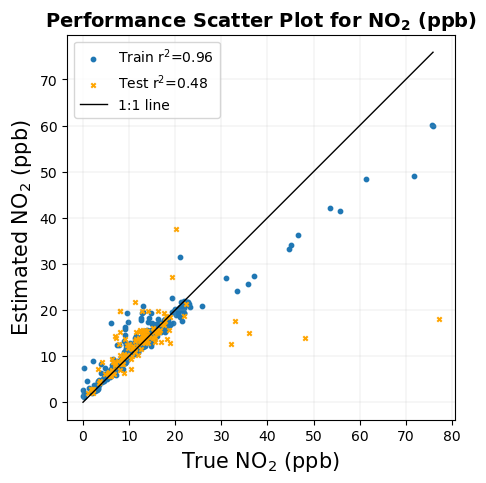

In [13]:
## Lets plot the scatter plot

import matplotlib as mpl
mpl.rcParams['mathtext.default']='regular'

plt.figure(figsize=(5,5))
plt.scatter(y_train, train_prediction_RF,s=10,c='C0',label='Train $r^2$={}'.format(correlation_train))
plt.scatter(y_test, test_prediction_RF,marker='x',s=10,c='orange',label='Test $r^2$={}'.format(correlation_test))


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))
plt.plot([p1, p2], [p1, p2], 'black',label='1:1 line',linewidth=1)
plt.xlabel('True NO$_2$ (ppb)', fontsize=15)
plt.ylabel('Estimated NO$_2$ (ppb)', fontsize=15)
plt.axis('equal')
plt.title("Performance Scatter Plot for NO$_2$ (ppb)", fontsize=14,fontweight="bold")
plt.legend()
plt.grid(axis='both',linewidth=0.15)
plt.show()

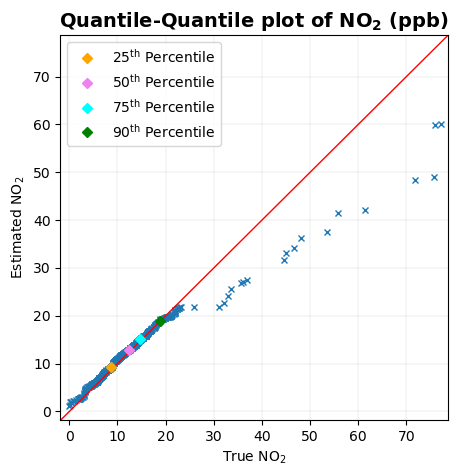

In [14]:
## Lets now plot the quantile quantile plot

import statsmodels.api as sm
import scipy.stats as stats

all_preds_NO=np.concatenate((train_prediction_RF,test_prediction_RF)) ## the list of all predictions and target values

preds=np.sort(all_preds_NO)
tars=target.sort_values()

plt.rc("figure", figsize=(5,5)) ## to make same figure size in statsmodels.api

pp_x = sm.ProbPlot(preds, fit=False)
pp_y = sm.ProbPlot(tars, fit=False)
qq = pp_x.qqplot(xlabel='True NO$_2$',ylabel='Estimated NO$_2$',marker='x',markersize=4,other=pp_y)

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1)
tars_25=np.percentile(tars,25)  ## for the percentiles                                                        
tars_50=np.percentile(tars,50)
tars_75=np.percentile(tars,75)
tars_90=np.percentile(tars,90)


preds_25=np.percentile(preds,25)
preds_50=np.percentile(preds,50)
preds_75=np.percentile(preds,75)  
preds_90=np.percentile(tars,90)  ## end of percentiles

plt.plot(tars_25,preds_25,marker="D",markersize=5,color="orange",linestyle ='None',label="$\mathrm{25^{th}}$ Percentile")
plt.plot(tars_50,preds_50,marker="D",markersize=5,color="violet",linestyle ='None',label="$\mathrm{50^{th}}$ Percentile")
plt.plot(tars_75,preds_75,marker="D",markersize=5,color="Cyan",linestyle ='None',label="$\mathrm{75^{th}}$ Percentile")
plt.plot(tars_90,preds_90,marker="D",markersize=5,color="Green",linestyle ='None',label="$\mathrm{90^{th}}$ Percentile")


plt.grid(axis='both',linewidth=0.15)

plt. title('Quantile-Quantile plot of NO$_2$ (ppb) ',fontsize=14,fontweight="bold")

plt.legend()
plt.show()


## Note that since the number of samples is the same, sorting the values in ascending or descending order and then...
## plotting a scatter plot will also do the same thing as the quantiles are located in same point for distribution..
## of same size.

In [15]:
## lets calculate the average values RMSE
from statistics import mean
j_train=[]
j_test=[]
k_train=[]
k_test=[]
for i in range(0,50):
    
    
    
    X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)
    final_model.fit(X_train,y_train)

    train_prediction=final_model.predict(X_train)
    mse_train=mean_squared_error(y_train,train_prediction)
    rmse_train=np.sqrt(mse_train)
    j_train.append(rmse_train)
    
    test_prediction=final_model.predict(X_test)

    mse_test=mean_squared_error(y_test,test_prediction)
    rmse_test=np.sqrt(mse_test)
    j_test.append(rmse_test)

## lets calculate the average correlation    
  
    train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
    correlation_train=int(train_r_sq*100)/100 ## display 
    k_train.append(correlation_train)
    
    test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
    correlation_test=int(test_r_sq*100)/100
    k_test.append(correlation_test)

average_train_rmse=mean(j_train)
average_test_rmse=mean(j_test)
    
average_train_rsq=mean(k_train)
average_test_rsq=mean(k_test)

print('The average train RMSE for NO2 is:::', '%.2f' % average_train_rmse)
print('The average test RMSE for NO2 is:::', '%.2f' % average_test_rmse)

print('The average train r square for NO2 is:::', '%.2f' % average_train_rsq)
print('The average test r square for NO2 is:::', '%.2f' % average_test_rsq)

The average train RMSE for NO2 is::: 2.80
The average test RMSE for NO2 is::: 7.44
The average train r square for NO2 is::: 0.93
The average test r square for NO2 is::: 0.26


In [16]:
print('The test RMSE error in each of the trail is:::', j_test)

The test RMSE error in each of the trail is::: [6.220399288445422, 11.131067783834107, 5.617331901667798, 5.567460550488352, 9.405621478166704, 7.203643300333035, 8.11905637123008, 5.485735888390863, 5.718013166014411, 6.783133235181939, 6.077899430804866, 8.225949011747803, 5.223875796351547, 7.497526113439014, 6.709738191008673, 7.4219669411259295, 6.216981276840168, 5.366797167880306, 9.769164108505771, 11.1168048162843, 5.261157071952422, 7.014881110743306, 10.621001812122758, 8.038968981254776, 6.117944483697368, 5.589171470401141, 7.41045747639757, 6.8456320885534625, 9.141272931252857, 8.149008082455202, 6.617979218580196, 10.134905751961364, 6.859015402365418, 6.730299124099722, 7.561077872453427, 10.209483461577852, 8.287601723387688, 5.107854381533741, 8.010951824806071, 8.446835918676117, 4.574902778042119, 8.647171299692738, 6.233065782704324, 9.579565382451682, 9.833766072254194, 7.799631464328601, 8.48812486178651, 6.308070981101241, 6.458507925679766, 7.107861054089691]


In [17]:
test_rmse=pd.DataFrame(j_test, columns=['R$^2$ in test set'])
test_rmse

,R$^2$ in test set
0,6.220399
1,11.131068
2,5.617332
3,5.567461
4,9.405621
5,7.203643
6,8.119056
7,5.485736
8,5.718013
9,6.783133


In [18]:
print('The r^2 in each of the trail in test set is:::', k_test)

The r^2 in each of the trail in test set is::: [0.21, 0.23, 0.36, 0.4, 0.29, 0.28, 0.25, 0.34, 0.31, 0.3, 0.24, 0.21, 0.4, 0.17, 0.26, 0.23, 0.35, 0.25, 0.21, 0.23, 0.27, 0.17, 0.15, 0.21, 0.37, 0.33, 0.26, 0.35, 0.3, 0.23, 0.21, 0.22, 0.21, 0.24, 0.27, 0.17, 0.25, 0.44, 0.14, 0.32, 0.38, 0.13, 0.3, 0.14, 0.26, 0.24, 0.27, 0.21, 0.3, 0.15]


In [19]:
test_r2=pd.DataFrame(k_test, columns=['R$^2$ in test set'])
test_r2

,R$^2$ in test set
0,0.21
1,0.23
2,0.36
3,0.40
4,0.29
5,0.28
6,0.25
7,0.34
8,0.31
9,0.30
